In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as col
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator
import matplotlib.lines as mlines
from matplotlib.pyplot import text
from scipy.optimize import curve_fit
import scipy.stats
%matplotlib inline

In [2]:
# font size and style
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 45}

matplotlib.rc('font', **font)
legsize = 30
axsize  = 22
marksize   = 13
majticklen = 20
minticklen = 10
tickwidth  = 5
cm = 'rainbow'

In [3]:
K_c      = 100e3     # average value from Petrovic 2003 (Fig 12.)/Kirchner et al 2000
E_c      = 8e9       # average value from Gold 2017 (Fig 12.)/Kirchner et al 2000
rho_i    = 917.0
D_glass_equiv = 0.377e-3

In [4]:
# surface area for oblate and prolate spheroid
def sphere_surf(a,c):
    if(a > c):
        eps = np.sqrt( 1 - c**2 / a**2 )
        A_surf = 2. * np.pi * a**2 + np.pi * c**2 / eps * np.log( (1 + eps) / (1 - eps))
    elif (a < c):
        eps = np.sqrt( 1 - a**2 / c**2 )
        A_surf = 2.* np.pi * a**2 + 2. * np.pi * a * c / eps * np.arcsin(eps)
    else:
        A_surf = 4. * np.pi * a**2
    return A_surf


# model function: formulation for N from Phillips et al 2017 with explicit C
def model_frag(X, b2):
    alpha_equiv, A, rho, K0, q, A_branch = X          
    
    C        = b2 * (1. - q) / (K_c**2 / E_c * A_branch)
    #print('b2',b2,'q', q,'K_c', K_c**2,'E_c', E_c,'A_branch', A_branch)
    return alpha_equiv * A * (1 - np.exp( - ((C * K0) / (alpha_equiv * A))**0.5  ))

# determine width of the branches for simplified asperity model
def branch(rho, a, c, A):
    return  (np.pi/4.) * ( rho/rho_i * max(a,c) / (A * sphere_surf(a,c) ) )**2

# coefficient of restitution fro Weir and Tallon 2005
def COR(rho_frag, r1, r2, dv):
    E_c    = 8e9
    Sy     = 5.2e6                        # quasi-static dynamic yield strength, weak dependency on strain rate
    E_dash = E_c / (1 - 0.3**2)

    D  = 1./ (1./r1 + 1/r2)               # Weir and Tallon Eq. 13
    
    # Weir and Tallon Eq. 54
    return 3.1 * (Sy / E_dash)**(5./8.) * (min(r1,r2) / D)**(3./8.) * (np.sqrt(E_dash/rho_frag) / dv )**(1./4.) 

# surface area of a volume-equivalent sphere
def surf_A_equiv(a,c):
    r_equiv = np.cbrt(a**2 * c)
    return 4. * np.pi * r_equiv**2

# number of asperities per unit area for an aggregate
def asperity_aggregate(a_mono,c_mono,A_mono, D_agg, mm):
    S_mono = sphere_surf(a_mono,c_mono)
    S_agg  = sphere_surf(D_agg*.5,D_agg*.5)
    return ((mm - 1.) + mm * S_mono * A_mono) / S_agg

In [5]:
# asperity density in order: plates, columns, needle, dendrites
A      = [ 6.37e9,  3.4e6, 3.4e6, 3.12e6]
# data from G&C '86: 
# max. dim, density, CKE, velocity and particles measured needed for 1 fragment; plate, prism, needle, dendrite
D_max  = 3e-3 
N      = [      1,      1,      1, 1]
rho_GC = [917.0,   835.06, 587.84, 388.6]
CKE_GC = [3.21e-7,4.55e-7,2.46e-7, 1.18e-8]
dv_GC  = [5.,6.,5.,1.]
phi_GC = [0.5,3,10,0.05]
a_GC   = [1.5e-3,0.5e-3,1.5e-4,1.5e-3]
c_GC   = [0.75e-3,1.5e-3,1.5e-3,0.75e-4]

In [6]:
# COR and equivalent area
e        = np.zeros(len(A))
alpha_eq = np.zeros(len(A))
for i in range(len(A)):
    e[i] = COR(rho_GC[i], 1.5e-3, 135e-6, dv_GC[i])
    # the smaller diameter governs the size of the area of impact
    alpha_eq[i] = min(surf_A_equiv(D_glass_equiv/2.,D_glass_equiv/2.), surf_A_equiv(a_GC[i],c_GC[i]))


In [7]:
b2       = np.zeros(len(A))
A_branch = np.zeros(len(A))
# calculation of b2 for particle types by taking results to produce 1 fragment
for i in range(len(A)):
    A_branch[i] = (np.pi/4.) * ( rho_GC[i]/rho_i * max(a_GC[i],c_GC[i]) / (A[i] * sphere_surf(a_GC[i],c_GC[i]) ) )**2
    #b2[i] = A[i] * alpha_eq[i] * np.log((A[i] * alpha_eq[i] - N[i]) / (A[i] * alpha_eq[i]) )**2 / CKE_GC[i] * K_c**2 / E *A_branch[i] / (1-e[i]) 
    b2[i] = (-np.log(1 - N[i]/(alpha_eq[i] * A[i])))**2 * (alpha_eq[i]*A[i]/CKE_GC[i]) * K_c**2 / E_c *A_branch[i] / (1-e[i])
print(b2)    


[1.85059343e-13 1.20261184e-02 1.34301413e-01 5.08063404e-02]


In [8]:
# quick check if calculatons are correct
for i in range(4):
    A_branch = branch(rho_GC[i], a_GC[i], c_GC[i], A[i])
    print(model_frag((alpha_eq[i],A[i],rho_GC[i],CKE_GC[i],e[i],A_branch),b2[i]))

0.9999999999999554
0.9999999999999999
0.9999999999999999
1.0


<h3>Results of Vardiman measurements</h3>

In [9]:
D_1 = 1e-3
D_2 = 1e-5
e   = 0.37
co_alpha = [3.234, 15.97, 76.36, 72.24, 14.16]
co_beta  = [0.6867, 9.261, 49.10, 39.56, 6.333]
co_gamma = [0., 1.432, 7.959, 5.52, 0.74]
crit     = [5.585e-4, 6.146e-4, 1.359e-3, 2.63e-4, 2.803e-4]

#formulae expect microns?!
def unrimed_dend(D):
    m = 0.0038 * (D * 1e3)**2 
    v = (8.4 * D**(0.217)) #/ 100.
    return m * 1e-6, v

def plane_dend(D,Fr):
    m = 0.027 * (D * 1e3)**2 
    if Fr == 0:
        v = 150. * (D * 100.)**0.301
    else:
        v = 170. * (D * 100.)**0.206
    return m * 1e-6, v / 100.

def N_vard(alpha, beta, gamma, l10):
    return alpha + beta * l10 + gamma * l10**2

def pow_vtp(arg_a, arg_b):
    return arg_a** arg_b


In [10]:
D         = np.logspace(-6,-1,401)
del_M     = np.zeros((3,len(D)))
del_M_gcm = np.zeros((3,len(D)))
K         = np.zeros((3,len(D)))
A_surf    = np.zeros((3,len(D)))
rho_ice   = np.zeros(len(D))
N_mod     = np.zeros((3,len(D)))
q         = np.zeros(len(D))

for j in range(3):
    for i,d in enumerate(D):
        dmm = 1000. * d
        if (dmm > 0.3):
            rho_ice[i] = 588. * pow_vtp(dmm, -0.377)
        else:
            rho_ice[i] = 588. * pow_vtp(0.3, -0.377)
        rho_ice[i] = min(rho_ice[i], 900.)
            
        if j == 0:
            m1, v1   = unrimed_dend(d)
        if j == 1:
            m1, v1   = plane_dend(d, 0)
        if j == 2:
            m1, v1   = plane_dend(d, 1)
        del_M[j][i]     = m1 * v1 * (1. + e)
        del_M_gcm[j][i] = del_M[j][i] * 1000. * 100.
        K[j][i]         = 0.5 * m1 * v1**2
        V_i             = m1 / rho_ice[i]
        A_surf[j][i]    = 4. * np.pi * np.cbrt(V_i * 0.75 / np.pi)**2
        r1       = D[i]/2.
        r2       = D[i]/2.
        q[i]     = COR(rho_ice[i], r1, r2, v1)
        if d <= 100e-6:
            k = 0
        else:
            k = 3
        A_branch = branch(rho_ice[i], r1, r2, A[k])
        N_mod[j][i] = model_frag((A_surf[j][i],A[k],rho_ice[i],K[j][i],q[i],A_branch),b2[k])

    
l10   = np.log10(del_M_gcm)

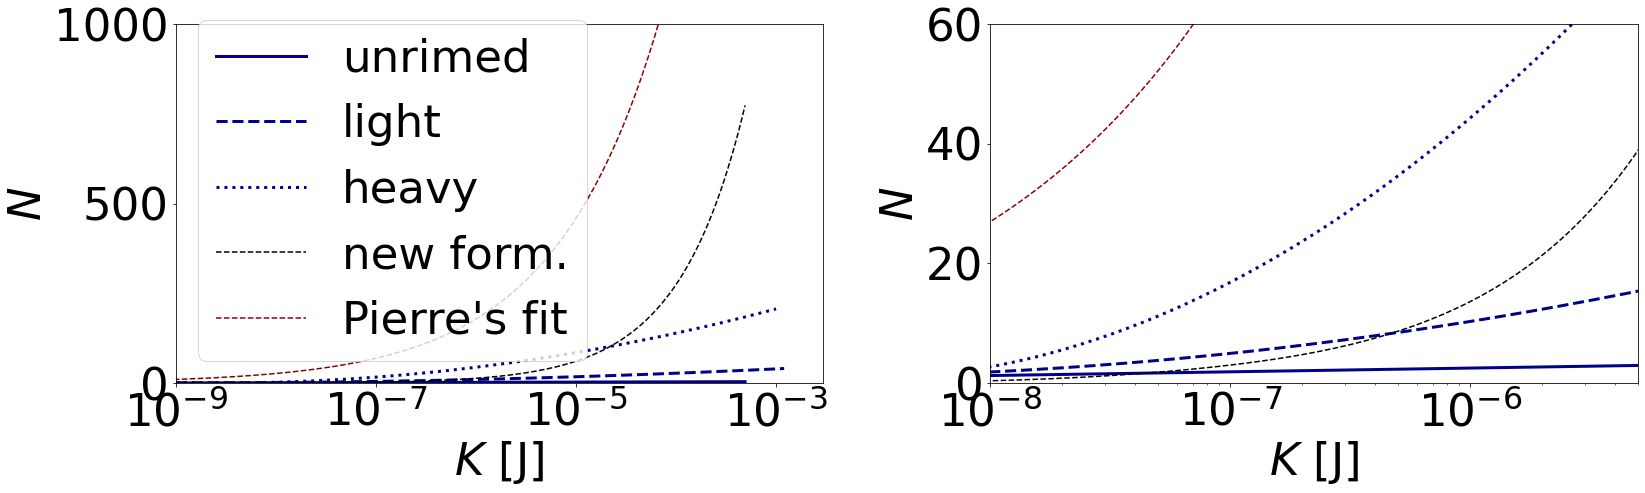

In [11]:
import numpy.ma as ma
plot = True
if plot == True:
    nrow = 1
    ncol = 2

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=[12*ncol,8*nrow])
    labels = ['unrimed', 'light', 'heavy', 'rimed', 'graupel']
    line   = ['-', '--', ':','-.',(0, (5, 2, 1, 2))]
    #ax = plt.subplot(nrow, ncol, 1)
    #plt.xscale('log')
    #plt.ylim(0,60)
    #plt.xlim(1e-4,1e0)
    #plt.xlabel('$\Delta M$')
    #plt.ylabel('$N$')
    #for i in range(3):
    #    N = N_vard(co_alpha[i],co_beta[i],co_gamma[i],l10[i])
    #    ax.plot(del_M_gcm[i], ma.masked_where(del_M_gcm[i] < crit[i], N), label=labels[i], linestyle=line[i])
    #plt.legend()

    ax = plt.subplot(nrow, ncol, 1)
    plt.xscale('log')
    plt.xlim(1e-9,3e-3)
    plt.ylim(0,1000)
    plt.xlabel('$K$ [J]')
    plt.ylabel('$N$')
    for i in range(3):
        N          = N_vard(co_alpha[i],co_beta[i],co_gamma[i],l10[i])
        ax.plot(K[i], ma.masked_where(K[i] < 1e-9, N), label=labels[i], linestyle=line[i], linewidth=3, c='darkblue')
    ax.plot(K[0],N_mod[0], c='black', label='new form.',linestyle=line[1])
    ax.plot(K[0], 5.14 * 1e4 * K[0]**0.41, linestyle='--', color='darkred', label='Pierre\'s fit')
    plt.legend()
    
    ax = plt.subplot(nrow, ncol, 2)
    plt.xscale('log')
    plt.xlim(1e-8,5e-6)
    plt.ylim(0,60)
    plt.xlabel('$K$ [J]')
    plt.ylabel('$N$')
    for i in range(3):
        N          = N_vard(co_alpha[i],co_beta[i],co_gamma[i],l10[i])
        ax.plot(K[i], ma.masked_where(K[i] < 1e-9, N), label=labels[i], linestyle=line[i], linewidth=3, c='darkblue')
    ax.plot(K[0],N_mod[0], c='black', label='new form.',linestyle=line[1])
    ax.plot(K[0], 5.14 * 1e4 * K[0]**0.41, linestyle='--', color='darkred', label='Pierre\'s fit')
    #plt.legend()
    
    #ax = plt.subplot(nrow, ncol, 2)
    #plt.xscale('log')
    #plt.xlabel('$D$ [m]')
    #plt.ylabel('$\\rho_\mathrm{app}$ [kg m$^{-3}$]')
    #plt.xlim(1e-6,1e-1)
    #plt.plot(D,rho_ice)
    fig.tight_layout()
    

<h3>Results of Pierre's measurements</h3>

In [12]:
# Particle data from Pierre's experiments
D_snow      = 1e-2
D_graupel   = 4e-3
rho_graupel = 510.
v_graupel   = 4.36
m_graupel   = 4./3. * np.pi * (D_graupel/2.)**3 * rho_graupel
#size-density assumptions by Heymsfield 04
rho_arm   = 0.01480 * (D_snow*100.)**(-0.74) * 1000  # = 14.8 (ARM)
rho_cryst = 0.0801  * (D_snow*100.)**(-0.95) * 1000  # = 80.1 (CRYSTAL)
rho_mean  = (rho_arm + rho_cryst)/2.                 # = 47.45

# P&K Tab2.6 and 10.5
m_snow = 0.037 * (D_snow*1000)**(1.4)                # m in mg, D in mm
v_snow = 1.3 * m_snow**(0.15)                        # v in cm/s, m in mg

m_snow = m_snow * 1e-6
v_snow = v_snow / 100.
no_mm  = 100.                                        # estimate by Pierre: 50-150 

# monomers of type P3b and P4d
m_mono = m_snow / no_mm

#P1e m = 6.12 * 10^-4 * D^2.29 # [g, cm]
#P2c m = 2.66 * 10^-3 * D^3.12 # [g, cm]

D_P1e = 0.161e-2 # [m]
D_P2c = 0.163e-2 # [m]

h = 4.5e-5  # [m]

phi    = D_P1e / (2 * h)   # = 0.056 = (1/18)
a_mono = D_P1e / 2.
c_mono = a_mono * phi

In [13]:
# read Data from Pierre's experiments
var     = ['CKE', 'N']
var2    = ['name', 'N', 'N_min', 'N_max', 'CKE', 'CKE_err', 'D_graup', 'D_graup_err', 'm_graup', 'm_graup_err', 'm_snow', 'm_snow_err', 'impact', 'v_graup', 'v_snow']
path    ='./input_files/'
file1   = path + 'Phillips_Takahashi_3a_CKE_points.dat'
file14  = path + 'Pierre_Fig14_points.dat'
file20  = path + 'pierre-graupel-snowflake/Graupel_snowflake_CKE_mass_size.txt'
tab1    = pd.read_csv(file1,  delimiter = ',', names=var) 
tab14   = pd.read_csv(file14, delimiter = ',', names=var) 
tabgs   = pd.read_csv(file20, delimiter = ' ', names=var2) 
#v_g      = [1.670,0.970,1.913,1.532,1.163,1.527]
#v_s      = [1.244,0.699,1.145,0.764,0.775,1.145]
# Pierre's fit
N_fit = 5.14 * 1e4 * tab14['CKE']**0.41
# error for CKE for graupel particles (extracted from files)
graupel_error = [5.927879617434876e-07, 2.533222395151227e-07, 2.246698350268315e-07, 7.574799674887515e-07, 8.918868793401822e-07, 8.208639495776669e-07
, 2.544187492669077e-06, 1.8004404080137946e-06, 1.5925793964551125e-06]
N_err = 0.1 * tab14['N'] # estimated to be 10%

In [14]:
Asp_agg     = asperity_aggregate(a_mono,c_mono,A[3], 1e-2, no_mm)
alpha_small = surf_A_equiv(D_graupel*.5,D_graupel*.5)
e_agg       = COR(rho_mean, D_snow *.5, D_graupel*.5, v_graupel-v_snow)

In [15]:
#fit data for aggregates
#nsub     = tabgs.loc[(tabgs['impact']>0.5)]
#nsub     = tabgs.loc[(tabgs['impact']>0.5)&(tabgs['N']<500)]
nsub     = tabgs.loc[(tabgs['N']<500)]
#nsub     = nsub.sort_values(by='CKE')

nlen     = len(nsub['CKE'])

alpha_sm = np.zeros(nlen)
Asp_agg  = np.zeros(nlen)
rho      = np.zeros(nlen)
e_agg    = np.zeros(nlen)
D_sn     = np.zeros(nlen)
A_branch = np.zeros(nlen)

nsub = nsub.set_index('name')

Dg = nsub['D_graup'] * 1e-4

for i in range(nlen):
    alpha_sm[i] = surf_A_equiv(Dg[i]*.5,Dg[i]*.5)
    m_sn        = tabgs['m_snow'][i] / no_mm
    a_mono      = (m_sn * 1000 / (6.12e-4) )**(1./2.29) / 100.     # P&K Tab.2.4 P1e crystals
    c_mono      = (9.022e-3 * (a_mono*100.)**(0.377) / 100.) / 2.  # P&K Tab.2.2b P1e crystals, h-formula
    Asp_agg[i]  = asperity_aggregate(a_mono,c_mono, A[3], D_snow, no_mm)
    rho[i]      = rho_mean
    e_agg[i]    = COR(rho[i], D_snow *.5, Dg[i]*.5, nsub['v_graup'][i] - nsub['v_snow'][i])
    D_sn[i]     = D_snow
    A_branch[i] = branch(rho[i], a_mono, c_mono, A[3])
    #print(alpha_sm[i], Asp_agg[i],rho[i],tabgs['CKE'][i],e_agg[i],A_branch[i])

sigma_N = nsub['N']*.1    
b2, pcov = curve_fit(model_frag, (alpha_sm, Asp_agg,rho,nsub['CKE'],e_agg,A_branch),nsub['N'],(1e-7),sigma=sigma_N)
print(b2,pcov)
N_modeled = model_frag((alpha_sm, Asp_agg,rho,nsub['CKE'],e_agg,A_branch),b2)
r, p      = scipy.stats.pearsonr(nsub['CKE'], N_modeled)
#print(N_modeled, nsub['N'])

[0.03744194] [[3.15639033e+09]]


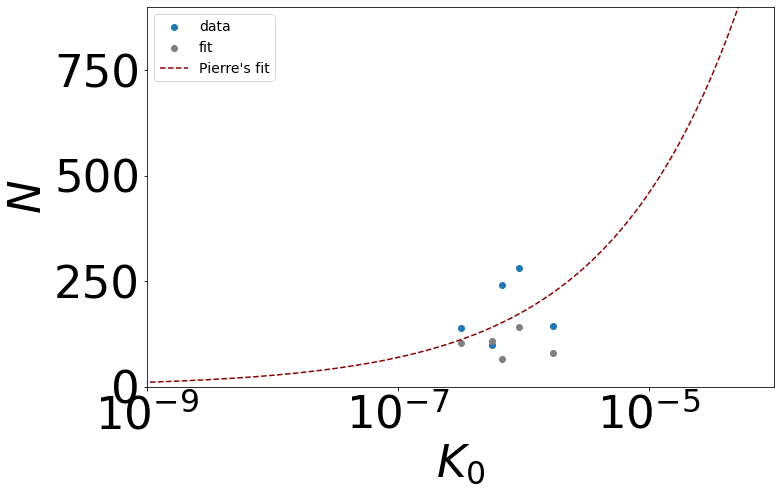

In [16]:
pp = PdfPages('./PDFs/frag_fit_noOutlier.pdf')
ncol, nrow = 1, 1
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=[12*ncol,8*nrow])
labels = ['unrimed', 'light', 'heavy', 'rimed', 'graupel']
line   = ['-', '--', ':','-.',(0, (5, 2, 1, 2))]
ax = plt.subplot(nrow, ncol, 1)
plt.xscale('log')
plt.ylim(0,900)
plt.xlim(1e-9,1e-4)
plt.xlabel('$K_0$')
plt.ylabel('$N$')

plt.scatter(nsub['CKE'],nsub['N'], label='data')
plt.scatter(nsub['CKE'],N_modeled, label='fit', color='gray')
ax.plot(K[0], 5.14 * 1e4 * K[0]**0.41, linestyle='--', color='darkred', label='Pierre\'s fit')

plt.legend(fontsize=14)
fig.tight_layout()
pp.savefig()


<h3>Results of Martanda's measurements</h3>

In [17]:
tab5  = pd.read_excel(path + 'Martanda_fragmentation_table.xlsx', header=1, names=['#','N','v','D_snow','D_sphere','m_snow','CKE'])
tab6  = pd.read_excel(path + 'Martanda_fragmentation_table2.xlsx', header=1, names=['#','N','v','D_snow','D_sphere','m_snow','CKE'])

frame_mart= [tab5, tab6]
mart_data=pd.concat(frame_mart, axis=0)
mart_data.reset_index(drop=True, inplace=True)
      

In [18]:
no_mm = 2
nlen     = len(mart_data)
alpha_mart = np.zeros(nlen)
Asp_agg  = np.zeros(nlen)
rho      = np.zeros(nlen)
e_agg    = np.zeros(nlen)
D_sn     = np.zeros(nlen)
A_branch = np.zeros(nlen)
rho      = np.zeros(nlen)
N_mart   = np.zeros(nlen)

for i in range(nlen):
    D_sn[i]       = mart_data['D_snow'][i] * 1e-3
    
    m_mono        = mart_data['m_snow'][i] / no_mm
    a_mart        = (m_mono * 1000 / (6.12e-4) )**(1./2.29) / 100.
    c_mart        = (9.022e-3 * (a_mart*100.)**(0.377) / 100.) / 2.
    Asp_agg[i]    = asperity_aggregate(a_mart,c_mart, A[3], D_sn[i], no_mm)
    rho_arm       = 0.01480 * (mart_data['D_snow'][i]/10.)**(-0.74) * 1000  # (ARM)
    rho_cryst     = 0.0801  * (mart_data['D_snow'][i]/10.)**(-0.95) * 1000  # (CRYSTAL)
    rho[i]        = (rho_arm + rho_cryst) / 2.                   
    e_agg[i]      = COR(rho[i], D_sn[i] *.5, mart_data['D_sphere'][i]*.5*1e-3, mart_data['v'][i])
    alpha_mart[i] = surf_A_equiv(D_sn[i] *.5, D_sn[i] *.5 )
    A_branch[i]   = branch(rho[i], a_mono, c_mono, A[3])
    #print(A_branch[i])

#b3, pcov3 = curve_fit(model_frag, (alpha_mart, Asp_agg, rho, mart_data['CKE'], e_agg, A_branch),mart_data['N'])
#print(b3,pcov3)          # [1.69841494e-07] [[3.22477075e-16]]
b3 = 1.69841494e-07
N_mart = model_frag((alpha_mart, Asp_agg, rho, mart_data['CKE'], e_agg, A_branch), b3)

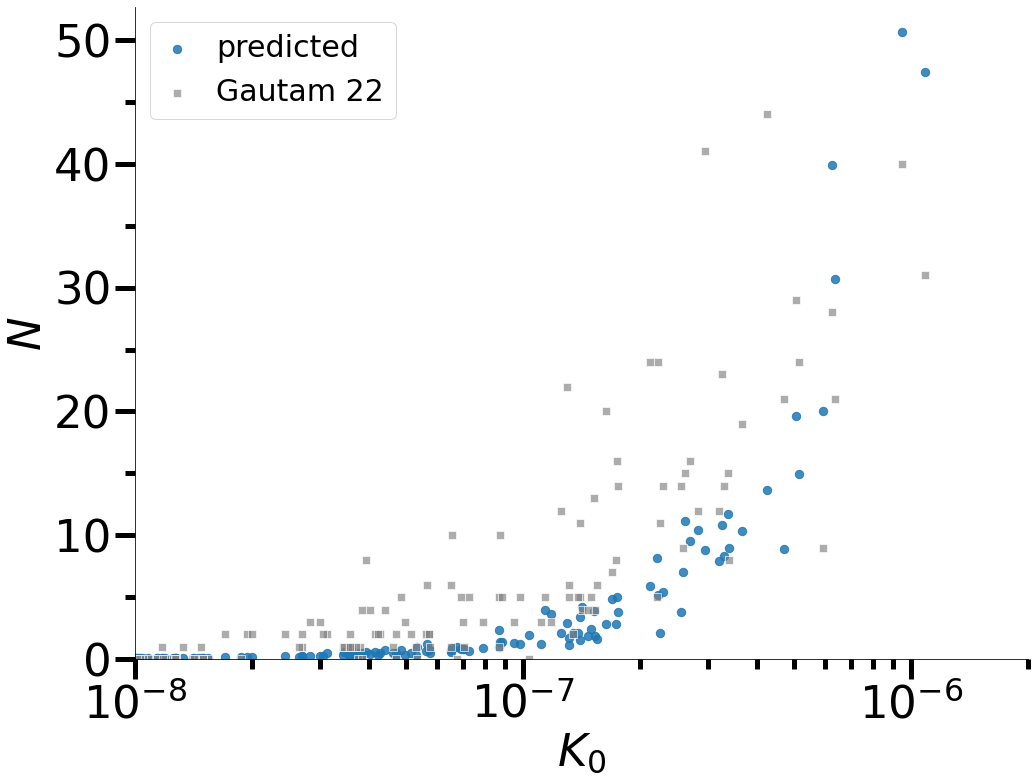

In [22]:
pp_mart = PdfPages('./PDFs/frag_fit_martanda_data.pdf')
fig = plt.subplots(nrows=1, ncols=1, figsize=[16,12])

ax1 = plt.subplot(1, 1, 1)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xscale('log')
ax1.set_ylim(0,max(np.amax(mart_data['N']),np.amax(N_mart) ) + 2)
ax1.set_xlim(1e-8,2e-6)
plt.xlabel('$K_0$')
plt.ylabel('$N$')
plt.scatter(mart_data['CKE'], N_mart, label='predicted', alpha=0.85, color='tab:blue', s=70)
plt.scatter(mart_data['CKE'], mart_data['N'], c ='grey', alpha=0.65, edgecolor='white', marker='s', label='Gautam 22', s=70)
ax1.tick_params(axis='both', which='major', length=majticklen, width=tickwidth)
ax1.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth)
ax1.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(fontsize = legsize, loc='upper left',columnspacing = 1, handlelength=1., frameon=True)
pp_mart.savefig()
#plt.scatter(tab6['CKE'], tab6['N'], c ='red', alpha=0.5, marker='s')

In [23]:
pp_mart.close()